# Фокусировние ультрафиолетового излучения - использование мета-линз

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft2
from scipy.fft import ifft2
from scipy.fft import fftfreq
from scipy.fft import fftshift
import pint

from matplotlib.animation import FuncAnimation
import matplotlib.patches as mpatches

u = pint.UnitRegistry()

## Теоретическая модель - необходимые функции

Функция для построения граничного поля

In [3]:
def plot_t(t: np.ndarray, x: np.ndarray, y: np.ndarray, colorbar_enabled: bool = False, plotable = plt):
    """Строит граничное поле(поле в плоскости z = 0)

    Args:
        t (np.ndarray): Массив содержащий изображение дифракционной решетки
        x, y (np.ndarray): Координаты 
        colorbar_enabled (bool): Строить ли colorbar на изображнии
        plotable: ax на которую следует наносить изображение(по умолчанию plt)
    """
    im = plotable.pcolormesh(x,y,t)
    if colorbar_enabled:
        plt.colorbar(im, ax = plotable)
    plotable.set_xlabel("x $мм$", fontsize = 16)
    plotable.set_ylabel("y $мм$", fontsize = 16)
    plotable.set_title("Функция пропускания, $z = 0_{+}$", fontsize = 16)

In [4]:
slitWidth, slitHeight = 0.25 * u.mm, 2 * u.mm
rectX = np.linspace(-2, 2, 2000) * u.mm # щель в квадратной пластинке 2 на 2 мм
x,y = np.meshgrid(rectX, rectX)
t = ((np.abs(x)< slitWidth/2) * (np.abs(y) < slitHeight/2)).astype(np.float64)

/home/vladimir/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:709: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.array(x, subok=True, copy=copy)


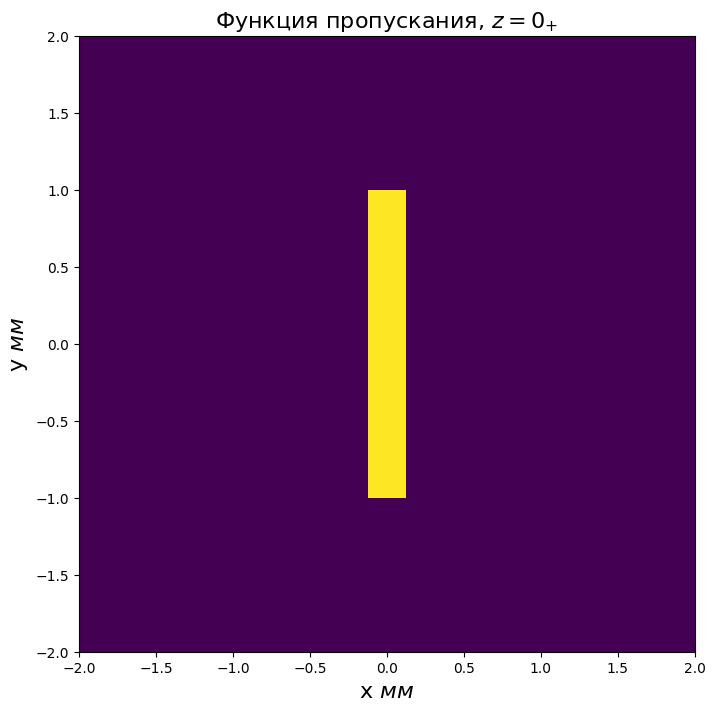

In [5]:
fig, ax = plt.subplots(figsize = (8,8), dpi = 100)
ax.set_aspect('equal')
plot_t(t, x, y, plotable = ax)

Рассчет пространственного спектра в области $z_{0+}$

In [6]:
def count_spectrum_z_0(t: np.ndarray, xAx: np.ndarray) -> tuple:
    """Рассчет пространственного спектра в области z_{0+}

    Args:
        t (np.ndarray): функция пропускания(изображение сетки)
        xAx (np.ndarray): Ось x

    Returns:
        tuple: kxv, kyv, f0
    """
    f0 = fft2(t)
    kx = fftfreq(len(xAx), np.diff(xAx)[0]) * 2 * np.pi
    kxv, kyv = np.meshgrid(kx,kx)
    return kxv, kyv, f0

In [7]:
def get_U(z, lamb, t, xAx):
    kxv, kyv, f0 = count_spectrum_z_0(t, xAx)
    k = 2 * np.pi / lamb
    return ifft2(f0*np.exp(1j*z*np.sqrt(k**2-(kxv**2+kyv**2))))

/home/vladimir/.local/lib/python3.10/site-packages/scipy/fft/_pocketfft/helper.py:98: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(x, dtype=dtype, copy=copy)


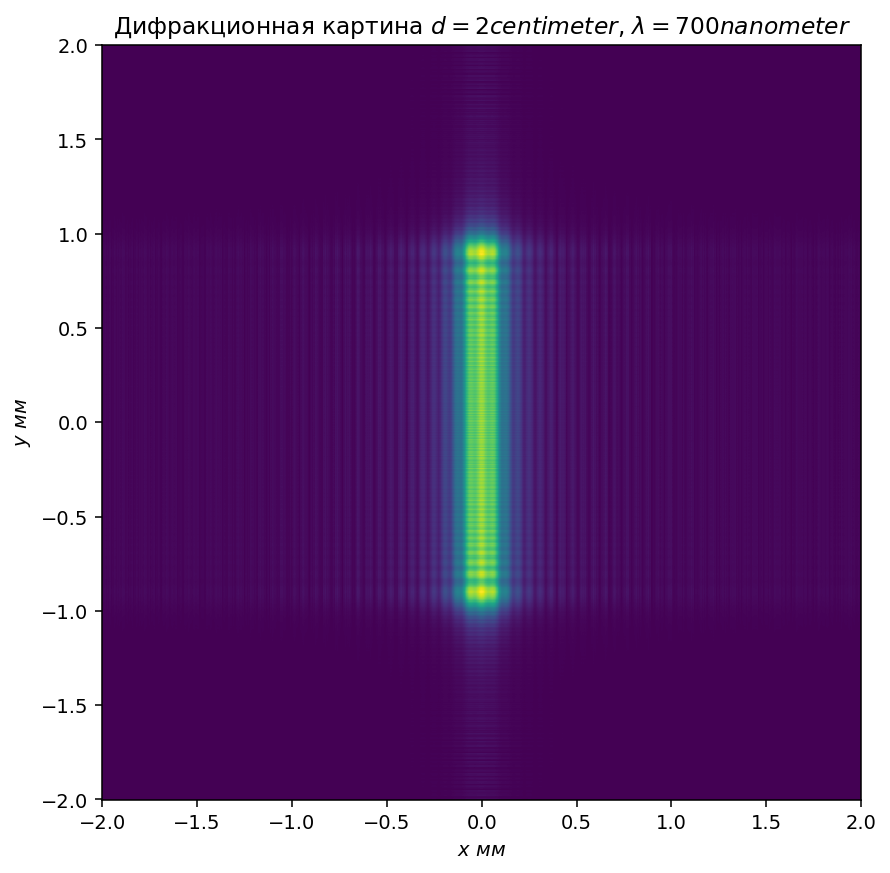

In [8]:
lamb = 700 * u.nm
lamb2 = 0.1 * u.nm
k = 2 * np.pi / lamb
distance = 2 * u.cm

fig, ax = plt.subplots(figsize = (7,7), dpi = 140)
plt.title("Дифракционная картина $d = {}$, $\lambda = {}$".format(round(distance,2), lamb) )
plt.xlabel("$x \ мм$")
plt.ylabel("$y \ мм$")
plt.pcolormesh(x,y,np.abs(get_U(distance,lamb = lamb, t = t, xAx = rectX)));

## Зонная пластинка Френеля

Попробуем создать зонную пластинку Френеля, с открытыми четными зонами. *Фокусное расстояние* такой пластинки находится по формуле:
$$
f = \frac{r_{m}^{2}}{m \lambda}
$$

Где $r_{m}$ - радиус $m-ой$ зоны Френеля:
$$
r_{m} = \sqrt{m \frac{ab}{a + b} \lambda}
$$

In [9]:
def get_r_m(a, b, lamb, m):
    """Рассчитывает радиус m-ой зоны френеля

    Args:
        a (_type_): _description_
        b (_type_): _description_
        lamb (_type_): длина волны
        m (_type_): номер зоны
    Returns:
        r (_type_): радиус m-ой зоны
    """
    return np.sqrt(m * a * b * lamb / (a + b))

In [22]:
a, b = 1000 * u.m, 100 * u.cm
lamb = 600 * u.nm
f = 1 / (1/a + 1/b)
r_m = [get_r_m(a, b, lamb, m) for m in np.arange(6 + 1)]

In [23]:
rectX = np.linspace(-10, 10, 2000) * u.mm 
x,y = np.meshgrid(rectX, rectX)
t = np.zeros_like(x)
for ind, r in enumerate(r_m):
    t += 2 * ((ind + 1)%2 - 0.5) * (np.power(x, 2) + np.power(y, 2) < np.power(r, 2)).astype(np.float64)
    

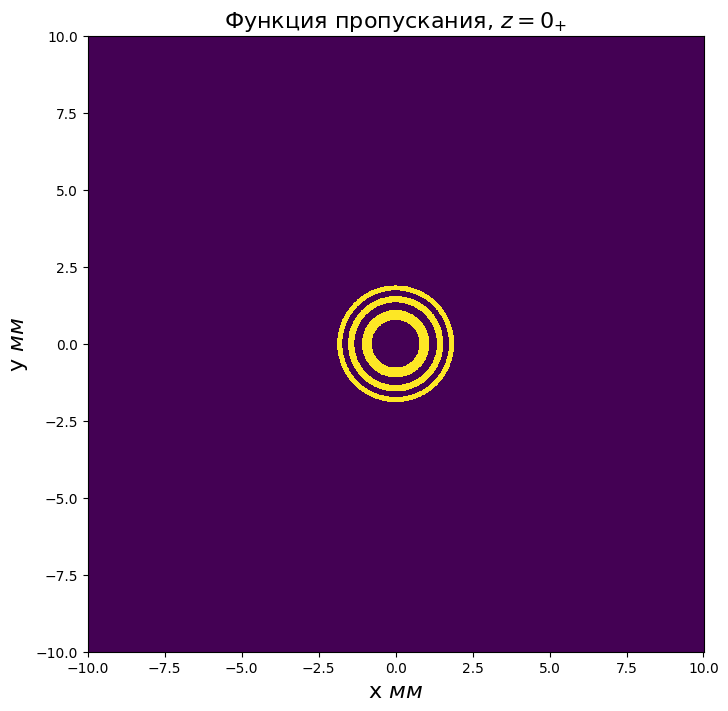

In [24]:
fig, ax = plt.subplots(figsize = (8,8), dpi = 100)
ax.set_aspect('equal')
plot_t(t, x, y, plotable = ax)

/home/vladimir/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:709: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.array(x, subok=True, copy=copy)
/home/vladimir/.local/lib/python3.10/site-packages/scipy/fft/_pocketfft/helper.py:98: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(x, dtype=dtype, copy=copy)


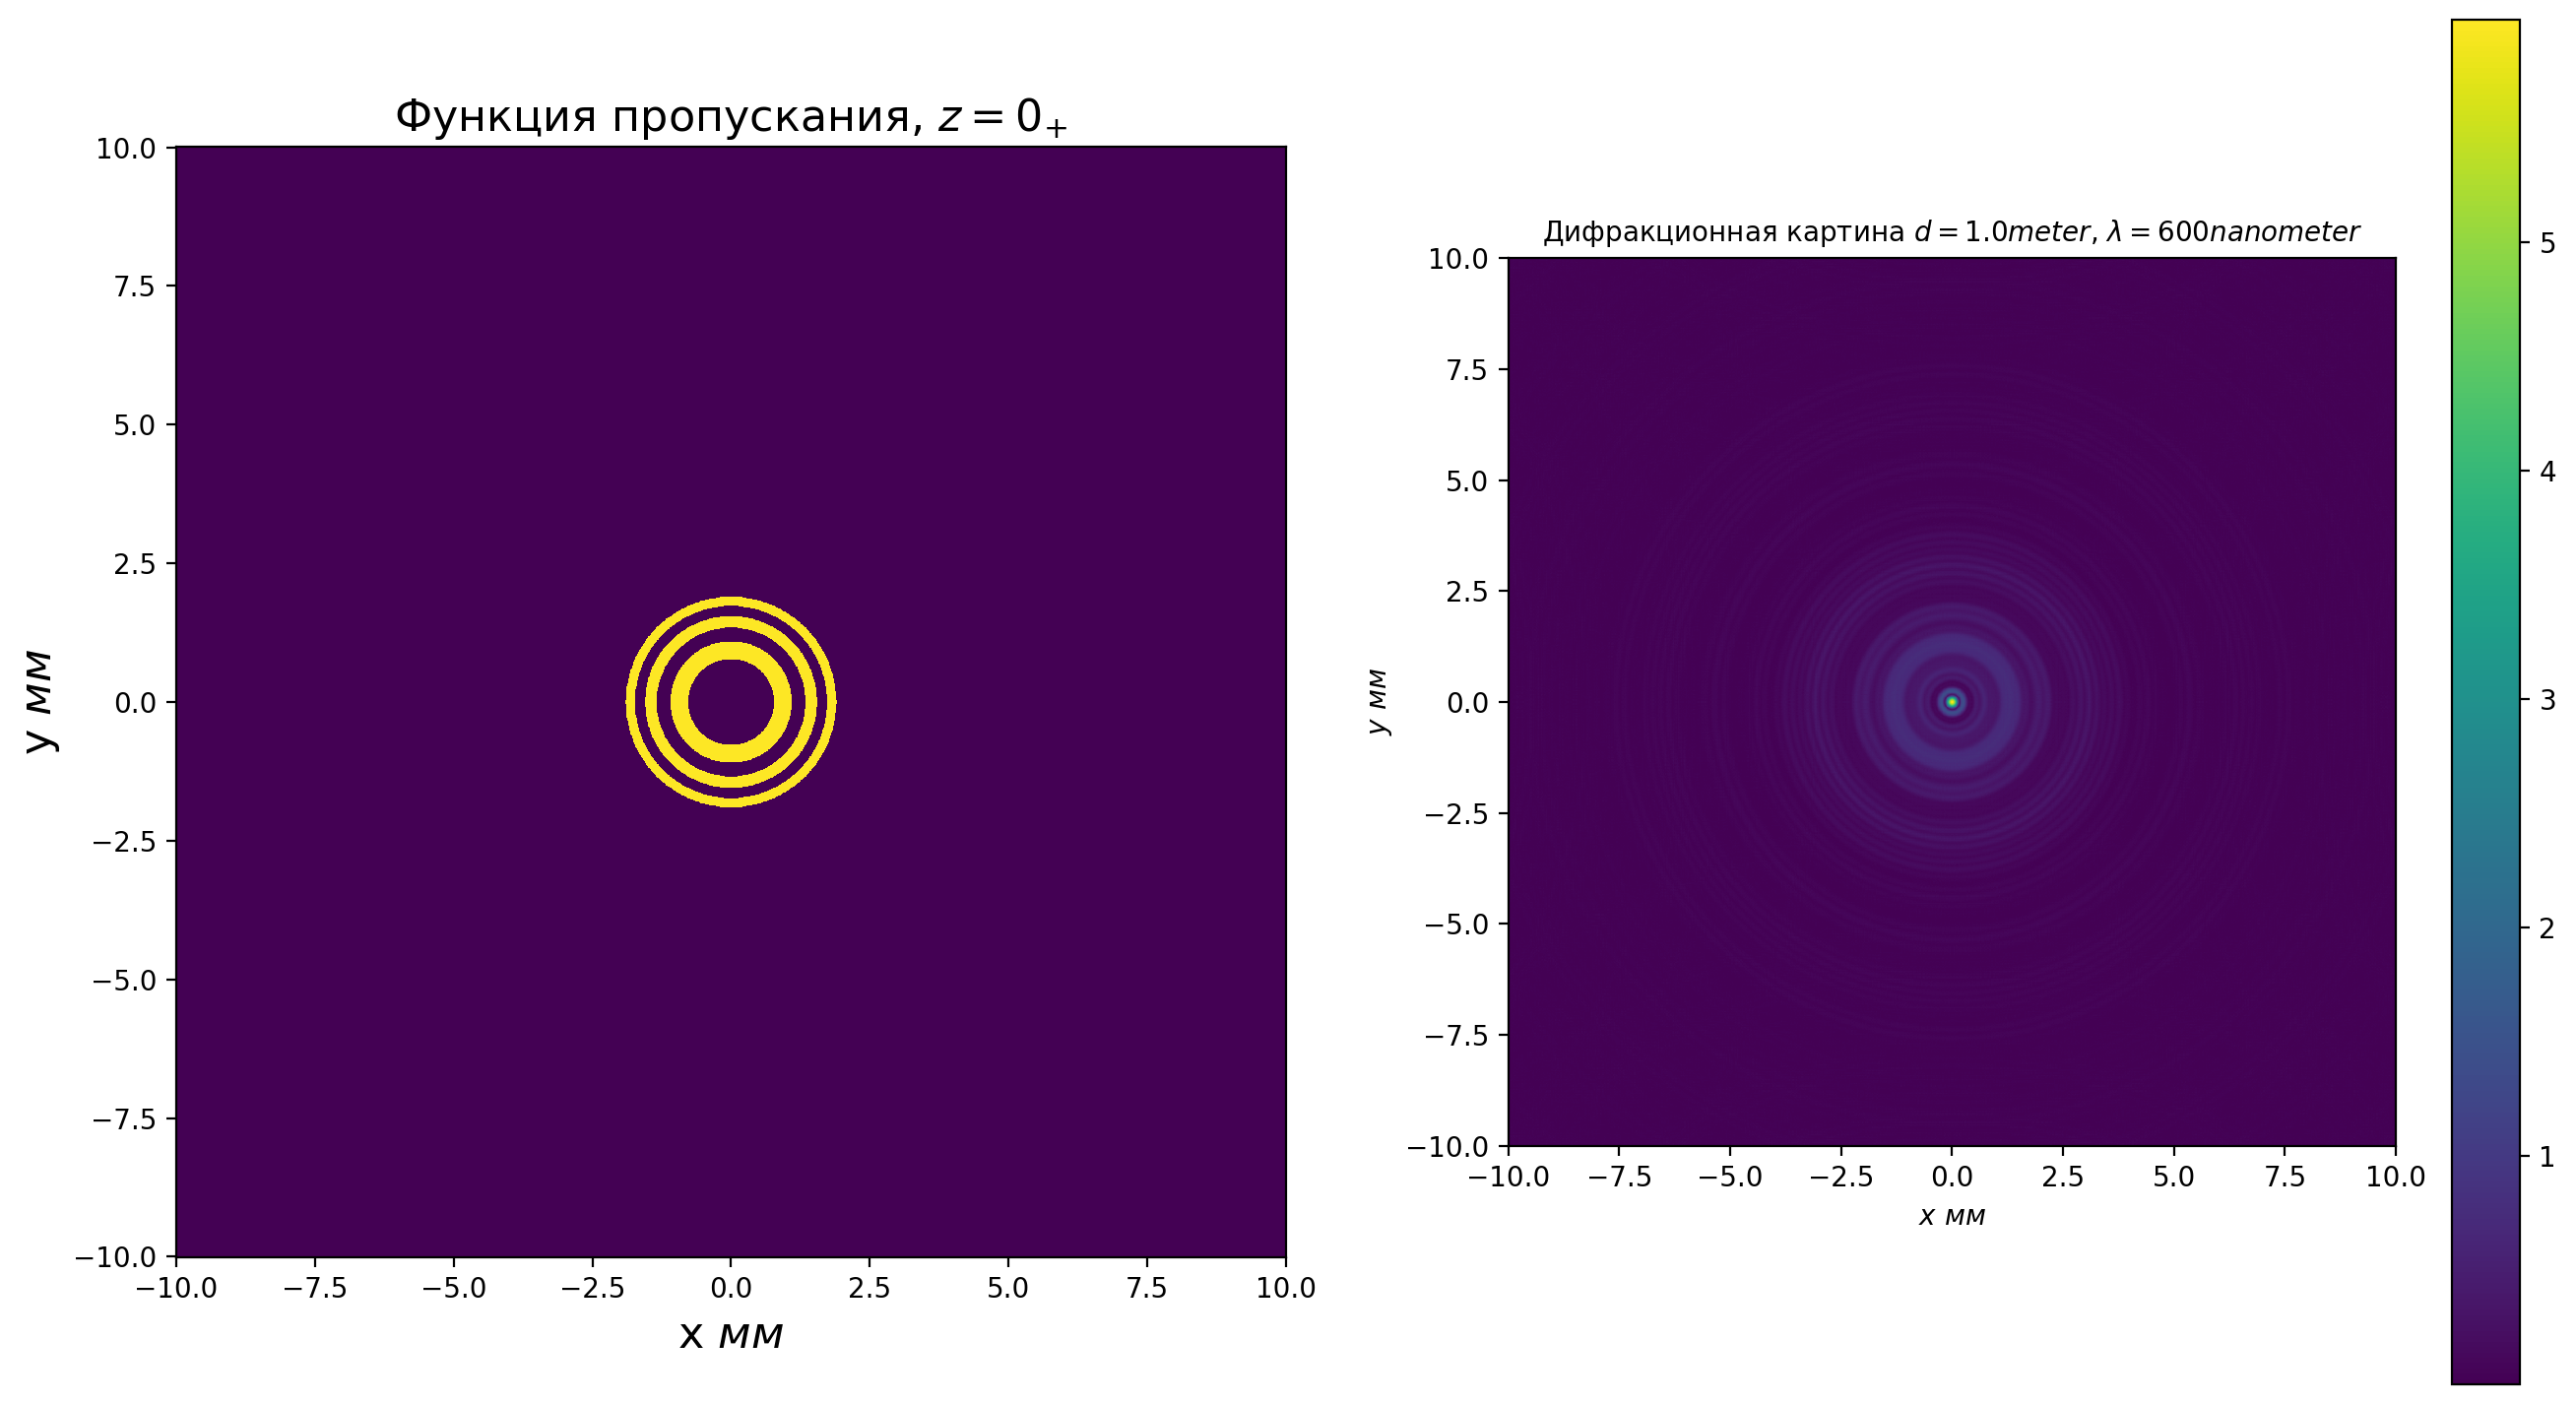

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (16, 9), dpi = 200)
for a in ax: a.set_aspect("equal")
plot_t(t, x, y, plotable = ax[0])

ax[1].set_title("Дифракционная картина $d = {}$, $\lambda = {}$".format(round(f,2), lamb), fontsize = 10)
ax[1].set_xlabel("$x \ мм$")
ax[1].set_ylabel("$y \ мм$")
im = ax[1].pcolormesh(x,y,np.abs(get_U(f,lamb = lamb, t = t, xAx = rectX)))
plt.colorbar(im, ax = ax[1]);

/home/vladimir/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


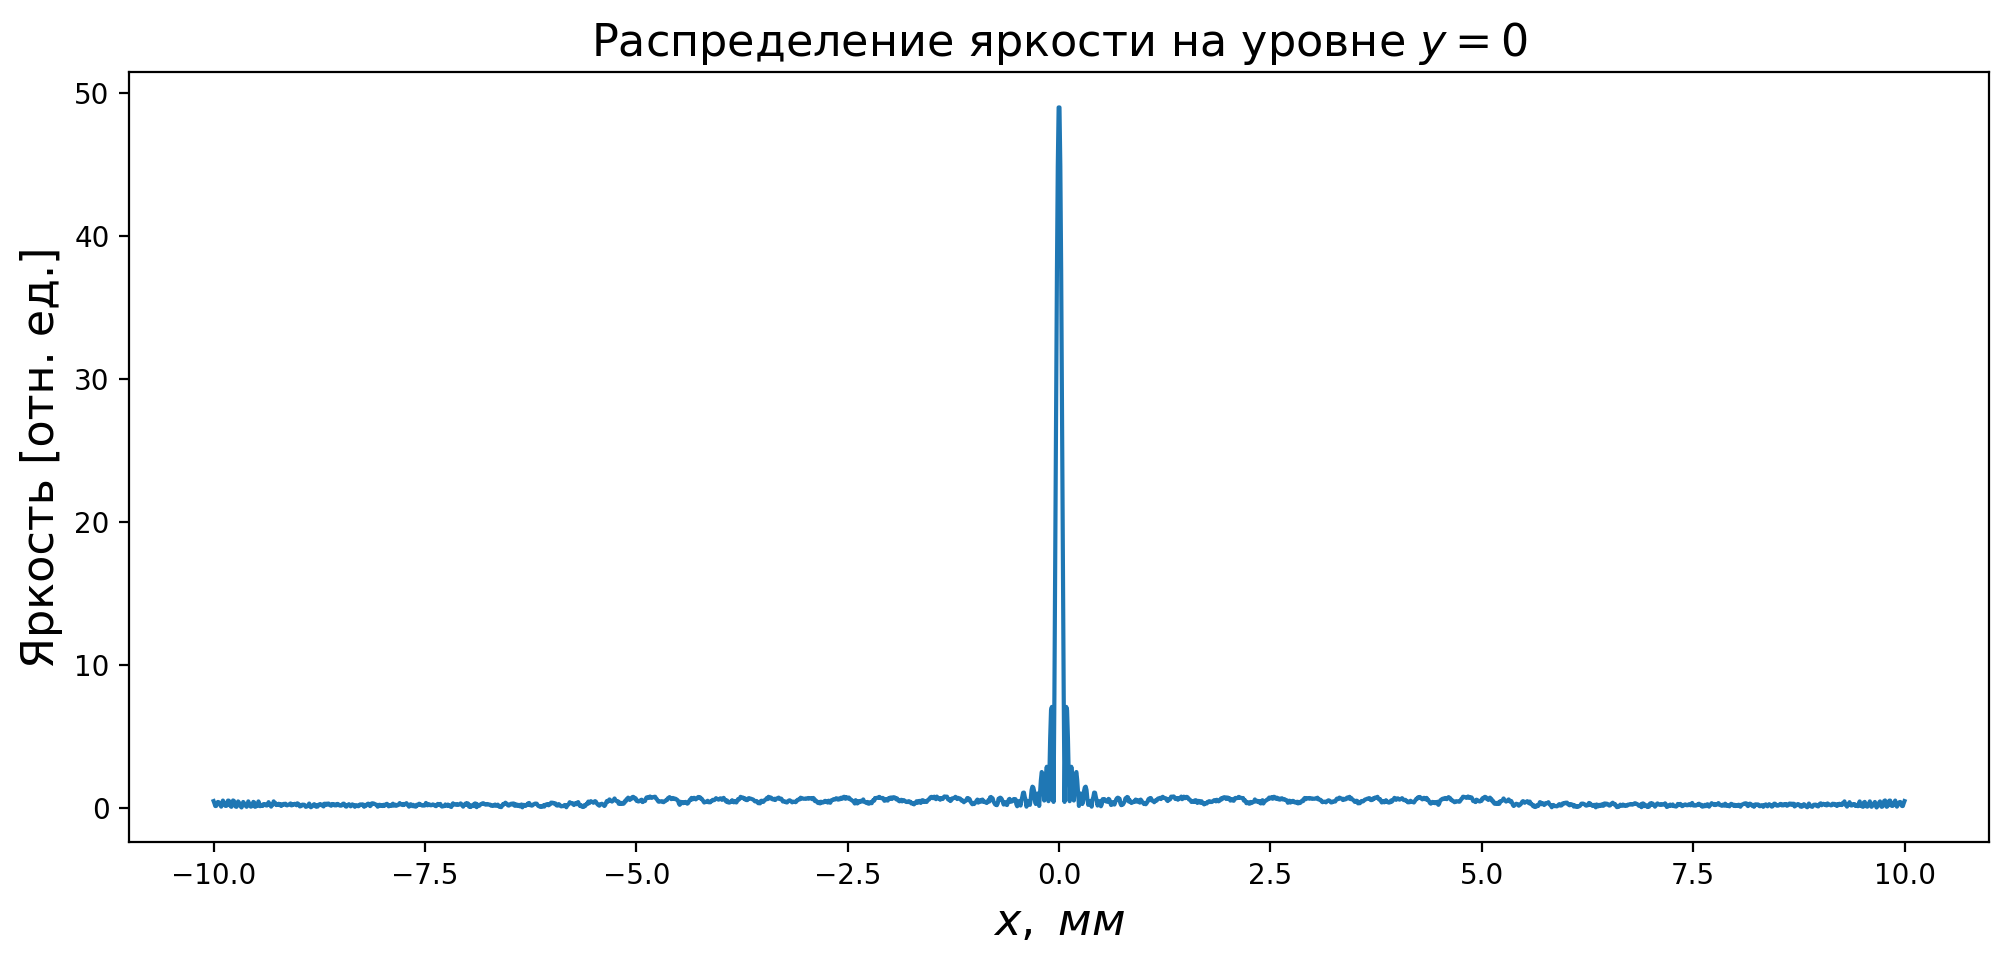

In [18]:
plt.figure(figsize = (12, 5), dpi = 200)
plt.title("Распределение яркости на уровне $y=0$", fontsize = 16)
plt.xlabel("$x, \ мм$", fontsize = 16)
plt.ylabel("Яркость [отн. ед.]", fontsize = 16)

plt.plot(rectX, np.abs(get_U(f,lamb = lamb, t = t, xAx = rectX))[1000]); 